In [115]:

# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn import model_selection
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc

%matplotlib inline



#    Dataset read and display

In [72]:
# Importing data
data = pd.read_csv('v0\Heart Attack Data Set.csv')
data = data.drop(labels=['fbs'],axis=1)
index_dropped_rows=[]

In [73]:
display(data)

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,1,115,1,1.2,1,1,3,0


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   restecg   303 non-null    int64  
 6   thalach   303 non-null    int64  
 7   exang     303 non-null    int64  
 8   oldpeak   303 non-null    float64
 9   slope     303 non-null    int64  
 10  ca        303 non-null    int64  
 11  thal      303 non-null    int64  
 12  target    303 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


# Finding Outliers

In [75]:
def deleterows(condition):
    deleted_rows = []
    for i,j in enumerate(condition):
        if(j == True):
            deleted_rows.append(i)
    return deleted_rows


index_dropped_rows.extend(deleterows(data['chol']>450))
index_dropped_rows.extend(deleterows(data['thalach']<80))



# One hot encoding for categorical Values

    RestECG: Resting electrocardiogram results
        0: normal
        1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        2: showing probable or definite left ventricular hypertrophy by Estes' criteria 8.
    Chest Pain type
        1: typical angina (all criteria present)
        2: atypical angina (two of three criteria satisfied)
        3: non-anginal pain (less than one criteria satisfied)
        4: asymptomatic (none of the criteria are satisfied)
    Slope: the slope of the peak exercise ST segment, ST-T abnormalities are considered to be a crucial indicator for identifying presence of ischaemia
        1: upsloping
        2: flat
        3: downsloping
    AHD:
        0 = normal
        1 = fixed defect (heart tissue can't absorb thallium both under stress and in rest)
        2 = reversible defect (heart tissue is unable to absorb thallium only under the exercise portion of the test)



In [76]:
from sklearn.preprocessing import OneHotEncoder

# Resting electrocardiogram results (restecg)

In [77]:
enc = OneHotEncoder(sparse=False)

encodedValues = enc.fit_transform(data[["restecg"]])

encodedValues = pd.DataFrame({
    "RestECG normal" : encodedValues[:,0],
    "RestECG abnormal" : encodedValues[:,1],
    "RestECG ventricular hypertrophy" : encodedValues[:,2],
})

data = pd.concat([data,encodedValues], axis=1)

data.pop("restecg")

data.head()

,age,sex,cp,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,target,RestECG normal,RestECG abnormal,RestECG ventricular hypertrophy
0,63,1,3,145,233,150,0,2.3,0,0,1,1,1.0,0.0,0.0
1,37,1,2,130,250,187,0,3.5,0,0,2,1,0.0,1.0,0.0
2,41,0,1,130,204,172,0,1.4,2,0,2,1,1.0,0.0,0.0
3,56,1,1,120,236,178,0,0.8,2,0,2,1,0.0,1.0,0.0
4,57,0,0,120,354,163,1,0.6,2,0,2,1,0.0,1.0,0.0


# Chest Pain (CP)

In [78]:
encodedValues = enc.fit_transform(data[["cp"]])

encodedValues = pd.DataFrame({
    "Chest Pain typical angina" : encodedValues[:,0],
    "Chest Pain atypical angina" : encodedValues[:,1],
    "Chest Pain non-anginal pain" : encodedValues[:,2],
    "Chest Pain asymptomatic" : encodedValues[:,3],
})

data = pd.concat([data,encodedValues], axis=1)

data.pop("cp")

data.head() 

,age,sex,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,target,RestECG normal,RestECG abnormal,RestECG ventricular hypertrophy,Chest Pain typical angina,Chest Pain atypical angina,Chest Pain non-anginal pain,Chest Pain asymptomatic
0,63,1,145,233,150,0,2.3,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37,1,130,250,187,0,3.5,0,0,2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,41,0,130,204,172,0,1.4,2,0,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,56,1,120,236,178,0,0.8,2,0,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,57,0,120,354,163,1,0.6,2,0,2,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Slope of the peak exercise ST segment

In [79]:


encodedValues = enc.fit_transform(data[["slope"]])

encodedValues = pd.DataFrame({
    "Slope Upscaling" : encodedValues[:,0],
    "Slope Flat" : encodedValues[:,1],
    "Slope Downscaling" : encodedValues[:,2]
})

data = pd.concat([data,encodedValues], axis=1)

data.pop("slope")

data.head()



,age,sex,trestbps,chol,thalach,exang,oldpeak,ca,thal,target,RestECG normal,RestECG abnormal,RestECG ventricular hypertrophy,Chest Pain typical angina,Chest Pain atypical angina,Chest Pain non-anginal pain,Chest Pain asymptomatic,Slope Upscaling,Slope Flat,Slope Downscaling
0,63,1,145,233,150,0,2.3,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,37,1,130,250,187,0,3.5,0,2,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,41,0,130,204,172,0,1.4,0,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,56,1,120,236,178,0,0.8,0,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,57,0,120,354,163,1,0.6,0,2,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:


encodedValues = enc.fit_transform(data[["thal"]])

encodedValues = pd.DataFrame({
    "AHD Normal" : encodedValues[:,0],
    "AHD Fixed Defect" : encodedValues[:,1],
    "AHD Reversible Defect" : encodedValues[:,2]
})

data = pd.concat([data,encodedValues], axis=1)

data.pop("thal")

data.head()



,age,sex,trestbps,chol,thalach,exang,oldpeak,ca,target,RestECG normal,...,Chest Pain typical angina,Chest Pain atypical angina,Chest Pain non-anginal pain,Chest Pain asymptomatic,Slope Upscaling,Slope Flat,Slope Downscaling,AHD Normal,AHD Fixed Defect,AHD Reversible Defect
0,63,1,145,233,150,0,2.3,0,1,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,37,1,130,250,187,0,3.5,0,1,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,41,0,130,204,172,0,1.4,0,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,56,1,120,236,178,0,0.8,0,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,57,0,120,354,163,1,0.6,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [81]:


#Removing outliers
data.drop(index=index_dropped_rows, inplace=True)



In [82]:
y = data.pop("target")
X = data

In [83]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [84]:
X.head()

,age,sex,trestbps,chol,thalach,exang,oldpeak,ca,RestECG normal,RestECG abnormal,...,Chest Pain typical angina,Chest Pain atypical angina,Chest Pain non-anginal pain,Chest Pain asymptomatic,Slope Upscaling,Slope Flat,Slope Downscaling,AHD Normal,AHD Fixed Defect,AHD Reversible Defect
0,63,1,145,233,150,0,2.3,0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,37,1,130,250,187,0,3.5,0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,41,0,130,204,172,0,1.4,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,56,1,120,236,178,0,0.8,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,57,0,120,354,163,1,0.6,0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [85]:

# Ver los valores únicos de las columnas para determinar si los datos son numéricos o categóricos 
X.nunique()

age                                 41
sex                                  2
trestbps                            49
chol                               150
thalach                             90
exang                                2
oldpeak                             40
ca                                   5
RestECG normal                       2
RestECG abnormal                     2
RestECG ventricular hypertrophy      2
Chest Pain typical angina            2
Chest Pain atypical angina           2
Chest Pain non-anginal pain          2
Chest Pain asymptomatic              2
Slope Upscaling                      2
Slope Flat                           2
Slope Downscaling                    2
AHD Normal                           2
AHD Fixed Defect                     2
AHD Reversible Defect                2
dtype: int64

In [86]:
categoric = X.drop(["age", "trestbps", "chol", "thalach", "oldpeak", "ca"], axis=1)
categoric.head()

,sex,exang,RestECG normal,RestECG abnormal,RestECG ventricular hypertrophy,Chest Pain typical angina,Chest Pain atypical angina,Chest Pain non-anginal pain,Chest Pain asymptomatic,Slope Upscaling,Slope Flat,Slope Downscaling,AHD Normal,AHD Fixed Defect,AHD Reversible Defect
0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [87]:
X = X[["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]]
X.head()

,age,trestbps,chol,thalach,oldpeak,ca
0,63,145,233,150,2.3,0
1,37,130,250,187,3.5,0
2,41,130,204,172,1.4,0
3,56,120,236,178,0.8,0
4,57,120,354,163,0.6,0


In [88]:
featureTags = list(X.columns)
featureTags.extend(categoric.columns)
featureTags

['age',
 'trestbps',
 'chol',
 'thalach',
 'oldpeak',
 'ca',
 'sex',
 'exang',
 'RestECG normal',
 'RestECG abnormal',
 'RestECG ventricular hypertrophy',
 'Chest Pain typical angina',
 'Chest Pain atypical angina',
 'Chest Pain non-anginal pain',
 'Chest Pain asymptomatic',
 'Slope Upscaling',
 'Slope Flat',
 'Slope Downscaling',
 'AHD Normal',
 'AHD Fixed Defect',
 'AHD Reversible Defect']

# Standarizing non categorical features

In [89]:
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 0.96451765,  0.75777921, -0.25201402,  0.00561546,  1.08565335,
        -0.71801704],
       [-1.91212683, -0.09799196,  0.09802825,  1.65138914,  2.11786706,
        -0.71801704],
       [-1.46956614, -0.09799196, -0.84914496,  0.9841836 ,  0.31149306,
        -0.71801704],
       [ 0.19003644, -0.66850607, -0.19024185,  1.25106582, -0.20461379,
        -0.71801704],
       [ 0.30067661, -0.66850607,  2.23946334,  0.58386027, -0.37664941,
        -0.71801704]])

In [90]:
categorical_array = categoric.to_numpy()
categorical_array[5:]

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [91]:
new_X = np.concatenate((X,categorical_array), axis=1)
new_X[5:]

array([[ 0.30067661,  0.47252215, -1.09623362, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19003644,  0.47252215,  1.00402002, ...,  0.        ,
         0.        ,  1.        ],
       [-1.13764563, -0.66850607,  0.36570764, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.51771851,  0.70072779, -1.0756429 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30067661, -0.09799196, -2.35226766, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30067661, -0.09799196, -0.19024185, ...,  0.        ,
         0.        ,  1.        ]])

In [92]:
for feature, val in zip(featureTags, new_X[0]):
    print(f"Feature {feature}\t\t-> {val}")

Feature age		-> 0.9645176487357586
Feature trestbps		-> 0.75777920555563
Feature chol		-> -0.25201401944889296
Feature thalach		-> 0.005615461966883296
Feature oldpeak		-> 1.085653347096595
Feature ca		-> -0.7180170412615353
Feature sex		-> 1.0
Feature exang		-> 0.0
Feature RestECG normal		-> 1.0
Feature RestECG abnormal		-> 0.0
Feature RestECG ventricular hypertrophy		-> 0.0
Feature Chest Pain typical angina		-> 0.0
Feature Chest Pain atypical angina		-> 0.0
Feature Chest Pain non-anginal pain		-> 0.0
Feature Chest Pain asymptomatic		-> 1.0
Feature Slope Upscaling		-> 1.0
Feature Slope Flat		-> 0.0
Feature Slope Downscaling		-> 0.0
Feature AHD Normal		-> 0.0
Feature AHD Fixed Defect		-> 1.0
Feature AHD Reversible Defect		-> 0.0


In [93]:

np.random.seed(0)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split (new_X, y, test_size=0.4, random_state=0)

In [94]:
print(f"Total number of data is {len(Y_train) + len(Y_test)}")

print(f"Cantidad de positivos datos en y_train\t= {len(Y_train[Y_train == 1])}")
print(f"Cantidad de positivos datos en y_test \t= {len(Y_test[Y_test == 1])}")
print(f"Cantidad de negativos datos en y_train\t= {len(Y_train[Y_train == 0])}")
print(f"Cantidad de negativos datos en y_test \t= {len(Y_test[Y_test == 0])}")

Total number of data is 301
Cantidad de positivos datos en y_train	= 103
Cantidad de positivos datos en y_test 	= 61
Cantidad de negativos datos en y_train	= 77
Cantidad de negativos datos en y_test 	= 60


In [95]:


print(f"Ratio of negatives over positives is {(len(Y_train[Y_train == 1])/len(Y_train))*100}%")
print(f"Ratio of negatives over positives is {(len(Y_test[Y_test == 1])/len(Y_test))*100}%")



Ratio of negatives over positives is 57.22222222222222%
Ratio of negatives over positives is 50.413223140495866%


# Usando Grid search para optimizar los parametros de training (kernel y C)

In [99]:
from sklearn.model_selection import GridSearchCV
svc = SVC()
C_range = list(range(1, 100))



param_grid = {
    'C': C_range,
    'kernel':['linear','poly','rbf','sigmoid']
}
  
# defining parameter range
grid = GridSearchCV(svc, param_grid, cv=3, scoring='roc_auc',verbose=0, n_jobs=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, Y_train)





In [100]:
print(grid.best_params_)

{'C': 1, 'kernel': 'linear'}


# Analizando resultados de precision para diferentes tamaños de margen variando 'C'

In [111]:
models = []

for i in [1,2,3,5,10,15,20,50,75,100]:
    model = SVC(kernel='linear', C=i)
    model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)
    models.append(score)


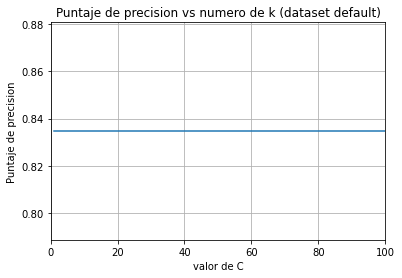

In [112]:
plt.title('Puntaje de precision vs numero de k (dataset default)')
plt.plot([1,2,3,5,10,15,20,50,75,100],models)
plt.xlabel('valor de C')
plt.ylabel('Puntaje de precision')
plt.xlim([0,100])
plt.grid()
plt.show()

# Entrenamiento con Parametros Optimizados 
Resultados en Accuracy

In [122]:

model = SVC(kernel='linear', C=1)
model.fit(X_train, Y_train)
print(f"The score of certainty for the SVC model is {model.score(X_test, Y_test)}")




The score of certainty for the SVC model is 0.8347107438016529


Prueba del generalizacion a traves de 5 nuevos entrenamientos con validaciones cruzadas 

In [123]:
model.support_vectors_
cv = 5
scores_res = model_selection.cross_val_score(model, new_X, y, cv=cv)
print(f'*{cv} folded cross validation scores:')
print(scores_res)
print(f'Average value: {scores_res.mean()}')

*5 folded cross validation scores:
[0.83606557 0.9        0.78333333 0.85       0.75      ]
Average value: 0.823879781420765


# Calculo de Recall y specificity

In [119]:
y_pred =model.predict(new_X)
y_true = y
f_score = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision = f_score[0]
recall = f_score[1]
f_score_val = f_score[2]
print(f'Recall: {precision}, Precision: {recall}, F_score: {f_score_val}')


Recall: 0.8560313075506445, Precision: 0.8441783870393449, F_score: 0.8472339705633565


# Curva de ROC y calculo de AUC

In [120]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y,y_pred)
print(f'roc_auc score: {roc_auc}')

roc_auc score: 0.8441783870393448


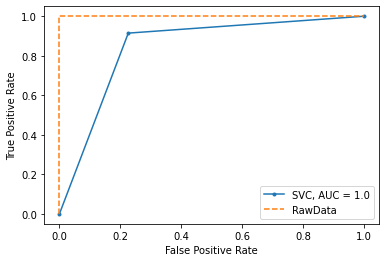

In [121]:
model_fpr= roc_curve(y,y_pred)
model_fpr, model_tpr, _ = roc_curve(y,y_pred)
ns_fpr, ns_tpr, _ = roc_curve(y,y)
svm_auc = auc(ns_fpr, ns_tpr)
# plot the roc curve for the model
plt.plot(model_fpr, model_tpr,  marker='.', label=f'SVC, AUC = {svm_auc}')
plt.plot(ns_fpr, ns_tpr,linestyle='--', label='RawData')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Visualizacion a traves de Matris de confusion

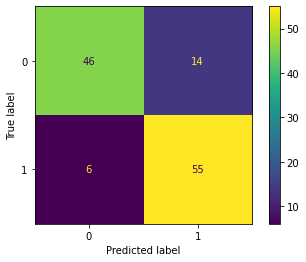

In [105]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



# Analisis de la importancia de cada feature para el modelo de SVC

In [106]:
modelCoeff = model.coef_[0]
for tag, val in zip(featureTags, modelCoeff):
    print(f"Feature {tag} importance\t -->\t{'{0:.4f}'.format(val)}")

Feature age importance	 -->	-0.0593
Feature trestbps importance	 -->	0.0258
Feature chol importance	 -->	-0.0567
Feature thalach importance	 -->	0.0002
Feature oldpeak importance	 -->	-0.6119
Feature ca importance	 -->	-0.5122
Feature sex importance	 -->	-0.6749
Feature exang importance	 -->	-0.6440
Feature RestECG normal importance	 -->	-0.1110
Feature RestECG abnormal importance	 -->	0.1248
Feature RestECG ventricular hypertrophy importance	 -->	-0.0138
Feature Chest Pain typical angina importance	 -->	-0.8459
Feature Chest Pain atypical angina importance	 -->	-0.4707
Feature Chest Pain non-anginal pain importance	 -->	0.2768
Feature Chest Pain asymptomatic importance	 -->	1.0398
Feature Slope Upscaling importance	 -->	0.2349
Feature Slope Flat importance	 -->	-0.4593
Feature Slope Downscaling importance	 -->	0.2244
Feature AHD Normal importance	 -->	0.0000
Feature AHD Fixed Defect importance	 -->	0.0000
Feature AHD Reversible Defect importance	 -->	1.2746


In [107]:
absoluteImportance = list((abs(val) for val in modelCoeff))

print(f"The most  important feature according to the Regression Model is {featureTags[absoluteImportance.index(max(absoluteImportance))]}")
print(f"The least important feature according to the Regression Model is {featureTags[absoluteImportance.index(min(absoluteImportance))]}")

The most  important feature according to the Regression Model is AHD Reversible Defect
The least important feature according to the Regression Model is AHD Normal


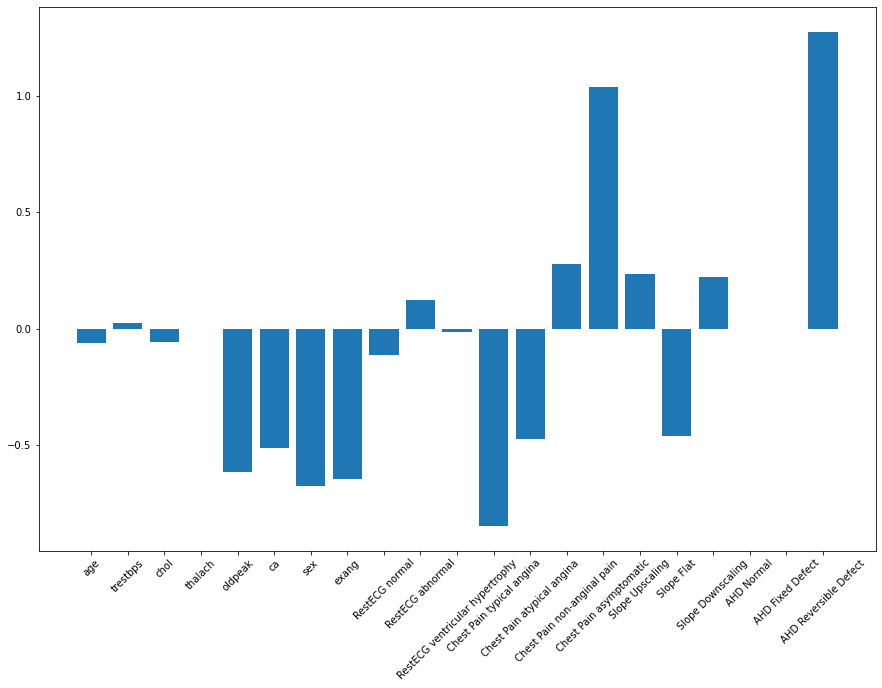

In [108]:


plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
plt.bar(featureTags, modelCoeff)
plt.show()

